# Novel Inertia Based Human Pose Estimation Using CNN

In [1]:
#setup
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
from utils import *

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

Autosaving every 180 seconds


In [3]:
#Import and augment data by rotating about y axis

from utils import *

f1 = "simulation/data/traj_9DOF_rel2start100k.txt"
f2 = "simulation/data/jointPos_9DOF_rel2start100k.txt"
numTraj = 100000
t, jointPos = add_body_rotation(f1, f2, numTraj, mult = 1)

# f3 = "simulation/data/traj_9DOF_250k.txt"
# f4 = "simulation/data/jointPos_9DOF_250k.txt"
# numTraj = 250000
# t2, jointPos2 = add_body_rotation(f3, f4, numTraj, mult = 1)


# print(jointPos[0])

saved augmented data as tbr, jbr


In [ ]:
#combine traj and jointpos from the two datasets

# print(np.shape(t),np.shape(t2))
# print(np.shape(jointPos),np.shape(jointPos2))

tCombined = np.concatenate((t,t2), axis = 0)
jointPosCombined = np.concatenate((jointPos,jointPos2), axis = 0)

print(np.shape(tCombined), np.shape(jointPosCombined))

t = tCombined
jointPos = jointPosCombined

In [4]:
#find and fix errors in data
err = np.argwhere(np.abs(jointPos) == 0)[:,0]
over_extended = np.argwhere(np.abs(jointPos) > 360)

print(err)
print(over_extended)

# Remove cells with errors instead of doubling existing cells
jointPos = np.delete(jointPos,err,axis = 0)
t = np.delete(t,err, axis = 0)

#replace empty trials with data from existing trials -> not a good idea...?
# for i in err[:,0]:
# #     print(jointPos[i])
#     randIndex = int(np.floor(np.random.rand()*np.shape(jointPos)[0]))
#     jointPos[i] = jointPos[randIndex]
#     t[i] = t[randIndex]

print(np.shape(jointPos))
print(np.shape(t))

# np.save("simulation/data/traj_combined", t)
# np.save("simulation/data/jointPos_combined", jointPos)

[   19    19    19 ... 99953 99953 99953]
[]
(98965, 10)
(98965, 10, 6)


In [ ]:
#load pre-rotated dataset

t = np.load("simulation/data/traj_combined.npy")
jointPos = np.load("simulation/data/jointPos_combined.npy")

In [30]:
from network import Net4 #for 10DOF model

np.random.seed(1337)

#convert data from numpy to tensors
x_train = tf.convert_to_tensor(t,np.float32)
y_train = tf.convert_to_tensor(jointPos,np.float32)

# print(tf.shape(x_train))
# print(x_train[0,:,1])

In [6]:
model = Net4()

runLen = 100    

def scheduler(epoch, lr):
#     part1 = 2*runLen//3
#     part2 = 5*runLen//6 #net1

    part1 = runLen//3
    part2 = 2*runLen//3 #net2

    if epoch < part1:
        lr = 0.01
        return lr
    if epoch >= part1 and epoch < part2:
        lr = 0.001
        return lr
    if epoch >= part2:
        lr = 0.0005
        return lr

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
#     loss=tf.keras.losses.MeanAbsoluteError(),
#     metrics=[tf.keras.metrics.MeanSquaredError()],
)

summary = model.summary()
print(summary)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

trace = model.fit(x=x_train, y=y_train, batch_size=128, epochs=runLen, verbose=1, 
                  validation_split=0.01, callbacks = [callback], shuffle=True)

#current best on combined dataset:
#   val_loss = 505
#   sum error on 10k test set: 0.97


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 6)]      0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 10, 6)        24          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 8, 16)        304         batch_normalization[0][0]        
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 8, 16)        784         conv1d[0][0]                     
_______________________________________________________________________________________

766/766 [==============================] - 25s 33ms/step - loss: 1984.9634 - val_loss: 1781.8954
Epoch 2/100
766/766 [==============================] - 24s 31ms/step - loss: 1635.7776 - val_loss: 1702.1827
Epoch 3/100
766/766 [==============================] - 24s 31ms/step - loss: 1535.2855 - val_loss: 1645.3115
Epoch 4/100
766/766 [==============================] - 24s 31ms/step - loss: 1446.1650 - val_loss: 1551.8256
Epoch 5/100
766/766 [==============================] - 24s 32ms/step - loss: 1387.4355 - val_loss: 1446.9141
Epoch 6/100
766/766 [==============================] - 24s 32ms/step - loss: 1350.2891 - val_loss: 1438.2170
Epoch 7/100
766/766 [==============================] - 24s 32ms/step - loss: 1312.1992 - val_loss: 1478.9637
Epoch 8/100
766/766 [==============================] - 24s 32ms/step - loss: 1274.8007 - val_loss: 1576.5936
Epoch 9/100
766/766 [==============================] - 24s 32ms/step - loss: 1239.1464 - val_loss: 1503.9789
Epoch 10/100
766/766 [=========

766/766 [==============================] - 25s 32ms/step - loss: 198.0954 - val_loss: 713.5696
Epoch 77/100
766/766 [==============================] - 25s 32ms/step - loss: 200.0367 - val_loss: 706.8163
Epoch 78/100
766/766 [==============================] - 24s 31ms/step - loss: 197.5192 - val_loss: 725.3683
Epoch 79/100
766/766 [==============================] - 24s 31ms/step - loss: 195.6889 - val_loss: 699.0942
Epoch 80/100
766/766 [==============================] - 24s 32ms/step - loss: 193.1334 - val_loss: 722.2367
Epoch 81/100
766/766 [==============================] - 24s 31ms/step - loss: 191.9819 - val_loss: 711.8839
Epoch 82/100
766/766 [==============================] - 24s 32ms/step - loss: 191.6103 - val_loss: 721.5729
Epoch 83/100
766/766 [==============================] - 24s 31ms/step - loss: 189.4838 - val_loss: 699.3542
Epoch 84/100
766/766 [==============================] - 24s 31ms/step - loss: 189.9941 - val_loss: 716.2792
Epoch 85/100
766/766 [===================

Text(0, 0.5, 'loss')

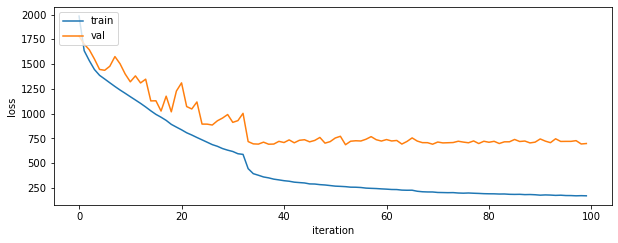

In [7]:
plt.subplot(2, 1, 1)
plt.plot(trace.history['loss'], '-')
plt.plot(trace.history['val_loss'], '-')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('iteration')
plt.ylabel('loss')
# plt.ylim(10,1000)

In [61]:
#load larger test dataset (for calculating accuracy of network)

ft1 = "simulation/data/traj_9DOF_10k.txt"
ft2 = "simulation/data/jointPos_9DOF_10k.txt"
numTraj = 10000 #number of trajectories given in base file

tTest, jointPosTest = add_body_rotation(ft1, ft2, numTraj, mult =1)

saved augmented data as tbr, jbr


In [88]:
#load single test case (for use with viz)
#DEBUG -> why does this perform better when data is generated with fast restart disabled??

ft1 = "simulation/data/traj_9DOF_1.txt"
ft2 = "simulation/data/jointPos_9DOF_1.txt"
ft3 = "simulation/data/jointPath.txt"
numTraj = 1 #number of trajectories given in base file

tTest, jointPosTest = add_body_rotation(ft1, ft2, numTraj, mult =1, actual_traj=ft3)

# print(tTest)
# print(jointPosTest) #issue when only one element in jointPos input file

saved augmented data as tbr, jbr, at


In [89]:
#test model- IMPORTANT TO USE NEVER BEFORE SEEN DATA

x_test = tf.convert_to_tensor(tTest,np.float32)
print(x_test)
y_test = tf.convert_to_tensor(jointPosTest,np.float32)

prediction = model.predict(x_test)
error = abs(y_test - prediction)

#average error for estimates for each joint
avg = np.average(error,axis=0)
print("average error = ", avg)

#range for each joint:
ranges = [50, 60, 67.5, 110, 120, 360, 130, 180, 110, 360]
rel_error = avg/ranges
print("error as frac of joint range = ", np.floor(rel_error*1000)/1000) #1 is full range of joint
print("total error = ",sum(rel_error))

print("prediction: ",prediction[0])
print("actual: ", y_test[0])

np.save("simulation/data/prediction.npy", prediction)

tf.Tensor(
[[[ 0.          0.          0.          0.          0.
    0.        ]
  [ 0.10951163 -0.077934   -0.20316371  0.26034    -0.13383
    0.28885   ]
  [ 0.24602187 -0.019759   -0.46568543  0.59084    -0.078596
    0.58208   ]
  [ 0.3289765   0.13609    -0.6271041   0.77063     0.048619
    0.73769   ]
  [ 0.37013215  0.28861    -0.6939169   0.86303     0.13096
    0.76589   ]
  [ 0.36146602  0.5752     -0.7078298   1.0205      0.34926
    0.82784   ]
  [ 0.17582197  0.95807    -0.3832654   1.1154      0.82767
    0.93644   ]
  [ 0.03664704  0.94379    -0.0876997  -0.62035     0.61947
   -0.0016883 ]
  [ 0.19452772  0.92578    -0.3725845   1.1163      0.686
    0.90565   ]
  [ 0.3665747   0.72409    -0.6412475   1.1037      0.42594
    0.70655   ]]], shape=(1, 10, 6), dtype=float32)
average error =  [2.9224400e+01 3.0353100e+01 5.9310089e+01 8.0722000e+01 1.1531200e+02
 3.6001001e+02 7.1644999e-02 1.3945999e+02 4.6769798e+01 1.2494695e+02]
error as frac of joint range =  [0.584

Best total error: 

1.52 @ 10k  dataset, mult 1, BS 128, MSE

1.29 @ 100k dataset, mult 2, BS 128, MSE

1.15 @ 100k dataset, mult 1, BS 128, MSE

1.10 @ 100k dataset, mult 1, BS 64,  MSE, Val loss = 851, 10 epoch

0.97 @ 100k dataset, mult 1, BS 128,  MSE, Val loss = 623, 30 epoch

0.86 @ 100k dataset, mult 1, BS 128,  MSE, Val loss = 556, 100 epoch

0.90 @ 250k dataset (replace errors with repeats), mult 1, BS 128, val loss = 476, 100 epoch

0.82 @ combined 650k dataset, mult 1, BS 128, MSE, val loss = 371, 100 epoch

Notes:
artifially creating more data by rotating about y axis at different angles is a bad idea. This teaches the network to memorize patterns of movement rather than learn the underlying dynamic models.

In [ ]:
# model.save("10DOF.kmod")

In [ ]:
#load best scoring model

# model = tf.keras.models.load_model("10DOF.kmod")

In [ ]:
#proof my model is doing better than completely random guessing

np.random.seed(None)

# print(actual)
# print(tf.shape(actual)) #[99 7]
B = tf.random.uniform([1000,7])

# B = tf.ones([99,7])
B = B *tf.constant([25., 30., 33.75, 55. , 60., 180., 65.]) + tf.constant([0., 0., 26.25, -35., 30., 0., -65.])

# print(tf.shape(B))
# print(tf.shape(actual))

fake_error = (y_test - B)
# print(fake_error)

fake_avg = tf.math.reduce_mean(tf.math.abs(fake_error), axis=0)
print(fake_avg)

rel_fake_error = fake_avg/ranges

print("error as frac of joint range: ",rel_fake_error)
print("total error: ", sum(rel_fake_error))

#NOTE: these are not all the same becuase the starting ranges for joint positions do NOT fall in the middle of all
#      possible positions for each joint

In [ ]:
from scipy.spatial.transform import Rotation as R
r = R.from_euler('zyx', [
[90, 0, 0],
[0, 45, 0],
[45, 60, 30]], degrees=True)

print(r)
r.as_quat()

v = [1, 2, 3]

r.apply(v)

In [ ]:
r1 = R.from_euler('z', 90, degrees=True)
r2 = R.from_euler('x', 90, degrees=True)
r3 = r1*r2

v = [1, 2, 3]

rot1 = r1.apply(v)
rot2 = r3.apply(v)
print(rot2)


In [ ]:
a, b, c= r3.apply([1, 2, 3])
print(a,b,c)


In [ ]:
#Import data from MatLab SimScape Multibody Simulator

#data comes from two files
#1) n trajectories in xyz space, each length m
# traj = np.loadtxt(open("C:/Users/Derm/Desktop/traj_with_angs_1M.txt", "rb"), delimiter=",")
traj = np.loadtxt(open("simulation/data/traj_9DOF_100k.txt", "rb"), delimiter=",")

trajPts = np.shape(traj)[0] #points per trajectory
# numTraj = np.shape(traj)[1]//3 #number of total trajectories
numTraj = np.shape(traj)[1]//6 #number of total trajectories


#traj needs to be reshaped to a 3d numpy array
#as is traj[n] shows [x,y,z,x,y,z...]


#2) 7 joint angles at the end of the sequence
# jointPos = np.loadtxt(open("C:/Users/Derm/Desktop/jointPos_with_angs_1M.txt", "rb"), delimiter=",")
jointPos = np.loadtxt(open("simulation/data/jointPos_9DOF_100k.txt", "rb"), delimiter=",")

# print(traj[-1])
# print(jointPos[0])



In [ ]:
#reshape traj data into 3d numpy array
# t = np.zeros([trajPts,3,numTraj]) #net 1
# for j in range(np.shape(traj)[0]):
#     for i in range(np.shape(traj)[1]//3):
#         t[j,:,i] = traj[j,3*i:3*(i+1)]
        
t = np.zeros([trajPts,6,numTraj]) #net 3
for j in range(np.shape(traj)[0]):
    for i in range(np.shape(traj)[1]//6):
        t[j,:,i] = traj[j,6*i:6*(i+1)]

        
# print(t[:,:,0]) #same as in MatLab
print(np.shape(t))
#swap axis so batch size is first axis (for TF)
t = np.swapaxes(t,0,2)
print(np.shape(t)) #[numTraj, xyz, trajPts]
#swap axis again so that conv1D moves on time and not xyz
t = np.swapaxes(t,1,2)
print(np.shape(t))